<a href="https://colab.research.google.com/github/dkaratzas/XNAP_Profs/blob/main/W04_01_MLP_for_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for image classification

In this notebook we are going to learn how to use a Multi-Layer Perceptron (MLP) for clasifing images. 

A MLP like the ones you used in the notebook of last week can be used with any kind of input data if we can represent it with a vector of real numbers. The shape of the input vector determines the size of the first layer in the model. In the case of images (2d arrays of pixel values) we can get fixed-lenght vectors by: (1) using images of the same size in all our dataset, and (2) flatenning the images into a 1d array. The flatten operation collapses an array into one dimension. For example, if we have a grayscale image of 28*28 pixels, its flattened version is a 1d array of 784 pixel values. Now we can fed these 784 values into a MLP for classifiying the image.

### Import the necessary libraries

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Use GPU if available

In [2]:
# If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Fashion-MNIST dataset

[**Fashion-MNIST**](https://pytorch.org/vision/0.8/datasets.html#fashion-mnist) is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. It was poroposed as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

Each training and test example is assigned to one of the following labels: 0 T-shirt/top, 1 Trouser, 2 Pullover, 3 Dress, 4 Coat, 5 Sandal, 6 Shirt, 7 Sneaker, 8 Bag, 9 Ankle boot.

The Fashion-MNIST dataset is available in [torchvision](https://pytorch.org/vision/stable/index.html) and can be loaded with the following code:


In [3]:
train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

print(train_set.data.size(), val_set.data.size())
print(train_set.targets.size(), val_set.targets.size())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


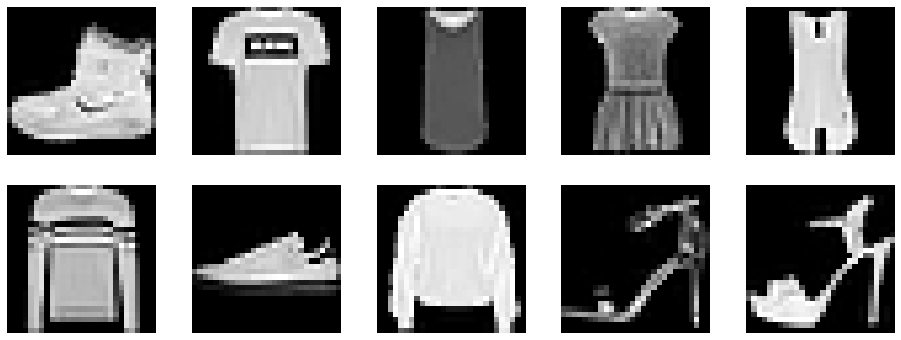

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = train_set.data[i,...]
    plt.imshow(image.squeeze().numpy(), cmap="gray")
    plt.axis('off');

## The dataloaders

Now we introduce a **critical piece in any deep learning training process**: the dataloader. In Pytorch we can create a dataloader for a given dataset as follows:


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

# Exercise 1

1.1. Take a look at the documentation of [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) and answer the following questions:

- What are the benefits of a dataloader?
- How can we make the dataloaders defined above better? 

1.2. When we loaded the Fashion-MNIST dataset we used the method `transforms.Compose`. Take a look at the documentation of [torchvision.transforms](https://pytorch.org/vision/0.8/transforms.html?highlight=transforms) and answer the following question:

- Is there another transform that we can add to make our classification problem easier?

In [6]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2860,), (0.3205,))])

train_set = datasets.FashionMNIST("data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
val_set = datasets.FashionMNIST("data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=5)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=5)

# Exersice 2

Modify your best performing architecture from last week notebook and create a class model that can work for any input and output size (using the `__init__()` class constructor parameters)

### Fully connected model

In [7]:

class FCModel(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

## Parameter Initialization

In PyTorch the default parameter initialization depends on the layer type. For example, for the Linear layer the default initialization is defined [here](https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py#L87). Take a look and see if you recognize the initialization method.

You can find more initialization methods in the [`torch.nn.init`](https://pytorch.org/docs/stable/nn.init.html?highlight=init) module.

If necessary, you can change the default initialization of a layer as follows:

In [8]:
def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.ones_(w)
        
        if "bias" in name:
            nn.init.zeros_(w)   

## Create the model and initialize its parameters

In [9]:
learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

# utility function to count number of parameters in a model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

print(f"Number of parameters {get_n_params(model)}:")

# move model to gpu if available
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# WARNING! What are we doing here?
initialize_parameters(model)

Number of parameters 118282:


## Define the train and validation methods

In [10]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):

    val_loss = 0
    correct = 0

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()                                                              
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset),
        accuracy))


    return val_loss


def train(epoch, criterion, model, optimizer, loader):
    
    total_loss = 0.0

    model.train()

    for batch_idx, (data, target) in enumerate(loader):
        
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        # print loss every N iterations
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))


        total_loss += loss.item()  #.item() is very important here? Why?

    return total_loss / len(loader.dataset)

### The training loop

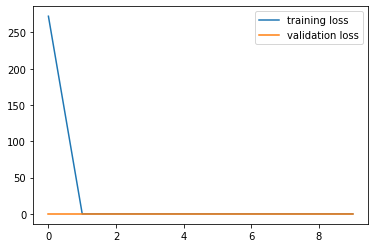

In [11]:
losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

# Homework

A) Change the initialization of the model parameters (this will help a great deal) and train your model on the Fashion-MNIST dataset.



In [12]:
# Parameter initialization with the Kaiming method 

def initialize_parameters(model):
    for name, w in model.named_parameters():
        if "weight" in name:
            nn.init.kaiming_uniform_(w, nonlinearity='relu')
        
        if "bias" in name:
            nn.init.zeros_(w)
            

learning_rate = 1e-3
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel(input_size, 128, output_size)

# move model to gpu if available
model.to(device)

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lambda_l2) # built-in L2

# initialize parameters with our own method
initialize_parameters(model)

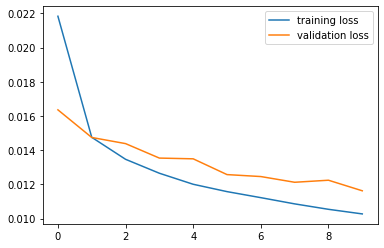

In [13]:
# the training loop

losses = {"train": [], "val": []}
for epoch in range(10):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

In [14]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0116, Accuracy: 8670/10000 (87%)



B) Try to improve the Accuracy of your model on the validation set by adding more layers and/or more hidden units in you model. For example you can use a MLP with 2 hidden layers with 512 and 256 units respectively.

In [15]:
# There are many possible configurations here
# In this example we use a model with three layers (with 256, 128, 64 neurons) 
# we also increase the batch size to 200 and the learning rate to 0.1


class FCModel2(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCModel2, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            # Your code here
            nn.Linear(input_size, n_hidden[0]), 
            nn.ReLU(), 
            nn.Linear(n_hidden[0], n_hidden[1]), 
            nn.ReLU(), 
            nn.Linear(n_hidden[1], n_hidden[2]), 
            nn.ReLU(), 
            nn.Linear(n_hidden[2], output_size),
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True, num_workers=5)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=200, shuffle=True, num_workers=5)

learning_rate = 0.1
lambda_l2 = 1e-5
torch.manual_seed(0) # seed for reproductibility

input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

model = FCModel2(input_size, (256,128,64), output_size)

# move model to gpu if available
model.to(device)

# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=lambda_l2) # built-in L2


# initialize parameters with our own method
initialize_parameters(model)

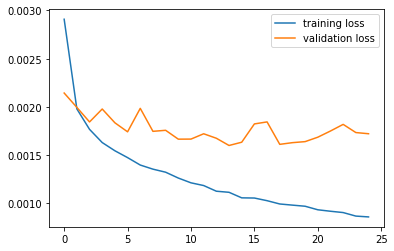

In [16]:
# the training loop

losses = {"train": [], "val": []}
for epoch in range(25):

    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    
     
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    
    display.clear_output(wait=True)

    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()   

In [17]:
# evaluate the trained model on the validation set
_ = validate(criterion, model, val_loader)


Test set: Average loss: 0.0017, Accuracy: 8909/10000 (89%)



C) Try at least two different [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) (e.g. SGD with momentum, RMSProp, Adam, etc.) and plot **in a single matplotlib figure** the loss curves for training the model with them. We want them in a single figure to be able to easily compare the three learning curves.

In [18]:
# Your code here

# save the previous loss values (SGD with momentum) to plot them later
all_losses = [losses.copy()]


torch.manual_seed(0) # seed for reproductibility
model = FCModel2(input_size, (256,128,64), output_size)
model.to(device)

# RMSProp with default parameters
optimizer = optim.RMSprop(model.parameters())

# training loop
losses = {"train": [], "val": []}
for epoch in range(25):
    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
        
all_losses.append(losses.copy())



torch.manual_seed(0) # seed for reproductibility
model = FCModel2(input_size, (256,128,64), output_size)
model.to(device)

# Adam with default parameters
optimizer = optim.Adam(model.parameters())

# training loop
losses = {"train": [], "val": []}
for epoch in range(25):
    train_loss = train(epoch, criterion, model, optimizer, train_loader)
    val_loss = validate(criterion, model, val_loader)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
        
all_losses.append(losses.copy())

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.307561
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.682018
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.574340

Test set: Average loss: 0.0026, Accuracy: 8215/10000 (82%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.524982
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.604702
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.498099

Test set: Average loss: 0.0027, Accuracy: 7940/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.510327
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.450668
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.459810

Test set: Average loss: 0.0021, Accuracy: 8417/10000 (84%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.473781
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.418437
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.349621

Test set: Average loss: 0.0022, Accuracy: 8489/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.324488
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.336788
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.421580

Test set: Average loss: 0.0022

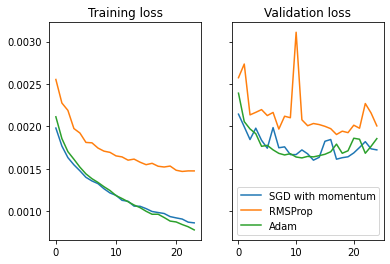

In [21]:
# Create two subplots 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.set_title('Training loss')
#discard the first value because it is usually very large
ax1.plot(all_losses[0]["train"][1:], label="SGD with momentum") 
ax1.plot(all_losses[1]["train"][1:], label="RMSProp")
ax1.plot(all_losses[2]["train"][1:], label="Adam")

ax2.set_title('Validation loss')
ax2.plot(all_losses[0]["val"], label="SGD with momentum")
ax2.plot(all_losses[1]["val"], label="RMSProp")
ax2.plot(all_losses[2]["val"], label="Adam")

plt.legend()
plt.show()   

D) Calculate the Accuracy for each individual class in the dataset and plot the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix) of your trained models.

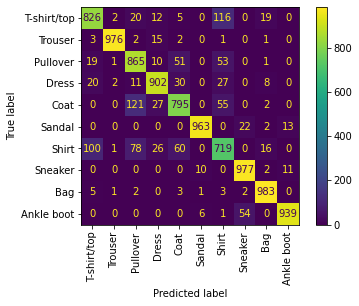

In [47]:
# Your code here

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

@torch.no_grad()  # prevent this function from computing gradients 
def evaluate(model, loader):

    predictions = []
    true = []

    model.eval()

    for data, target in loader:

        data, target = data.to(device), target.to(device)

        data = data.view(-1, 28*28)
        output = model(data)
        predictions += np.argmax(output.cpu().numpy(), axis=1).tolist()
        true += target.cpu().numpy().tolist()
        
    return true, predictions

true, pred = evaluate(model, val_loader)
cm = confusion_matrix(true, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_set.classes)
disp.plot(xticks_rotation='vertical') 

It may also be useful to visualize some qualitative examples of classification 

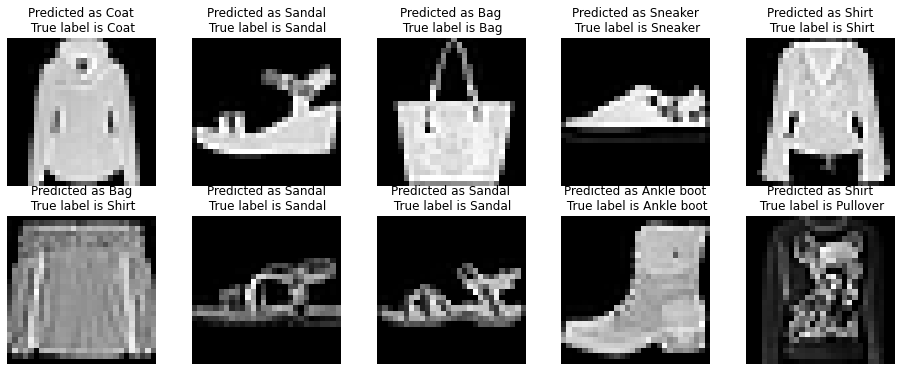

In [56]:
with torch.no_grad():

    data, target = next(iter(val_loader))
    data, target = data.to(device), target.to(device)

    data = data.view(-1, 28*28)
    output = model(data)
    predictions = np.argmax(output.cpu().numpy(), axis=1).tolist()
    true = target.cpu().numpy().tolist()
      
    plt.figure(figsize=(16, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        image = data[i,...].cpu().numpy().reshape((28,28))
        plt.imshow(image, cmap="gray")
        plt.axis('off')
        plt.title('Predicted as {}\n True label is {}'.format(val_set.classes[predictions[i]], val_set.classes[true[i]], ))